# Clasificación de Plantas - Comparación de Modelos

El objetivo principal de este experimento es evaluar y comparar tres arquitecturas de aprendizaje profundo (*Deep Learning*) con paradigmas distintos para determinar cuál ofrece el mejor compromiso (**trade-off**) entre precisión (*Accuracy*) y latencia de inferencia. La elección del modelo final es crítica: debe ser lo suficientemente ligero para no crear un cuello de botella antes de la detección de YOLO, pero lo suficientemente robusto para distinguir características morfológicas complejas en entornos naturales y no perjudicar al resultado final.

## Arquitecturas Evaluadas

Para este análisis comparativo se han seleccionado tres modelos que representan el estado del arte en diferentes enfoques de diseño de redes neuronales:

*   **EfficientNetV2 (S):** Representa la evolución de las Redes Convolucionales (CNNs) tradicionales. Utiliza una búsqueda de arquitectura neural combinada con *compound scaling* optimizado. Su principal innovación radica en el uso de bloques **Fused-MBConv**, que mejoran la velocidad de entrenamiento y la eficiencia de parámetros respecto a su predecesor (V1), manteniendo un alto rendimiento en benchmarks como ImageNet.
*   **MaxVit (Tiny):** Una arquitectura híbrida que busca unificar lo mejor de dos mundos: las CNNs y los Vision Transformers (ViT). Emplea un mecanismo de **atención multi-eje (Multi-Axis Attention)**, que permite al modelo capturar interacciones globales (contexto de toda la imagen) con complejidad lineal, mientras mantiene las convoluciones para la extracción de características locales (texturas de las hojas, bordes).
*   **MobileNetV3 (Small):** Diseñada específicamente para entornos de recursos limitados (móviles/IoT). Utiliza **convoluciones separables en profundidad (Depthwise Separable Convolutions)** y módulos de atención ligera (*Squeeze-and-Excitation*). Se incluye en la comparativa para evaluar si la ganancia en velocidad de inferencia justifica una potencial pérdida en precisión.

## Instalación de Dependencias

In [ ]:
!pip install torch torchvision timm pillow matplotlib numpy scikit-learn seaborn --quiet

## Imports y Configuración Inicial

In [ ]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
from collections import defaultdict

# Configurar dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Montar Google Drive

Esto permite acceder a los datos almacenados en Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración del Dataset y Transformaciones

En esta sección se define el pipeline de transformación de los datos de entrada. Dado que utilizaremos técnicas de **Transfer Learning** con modelos pre-entrenados en ImageNet, es imperativo alinear la distribución estadística de nuestras imágenes con las originales de dicha red.

### Justificación de las Transformaciones

1.  **Normalización Estadística:**
    Se utilizan la media `[0.485, 0.456, 0.406]` y la desviación estándar `[0.229, 0.224, 0.225]` derivadas del dataset ImageNet. Esto asegura que los pesos pre-entrenados del *backbone* reciban entradas con la misma distribución de intensidad para la que fueron optimizados, facilitando la convergencia del entrenamiento.

2.  **Data Augmentation (Solo Entrenamiento):**
    Para mitigar el **overfitting** (sobreajuste) y mejorar la capacidad de generalización del modelo, se aplican perturbaciones aleatorias a las imágenes de entrenamiento. Esto fuerza a la red a aprender características intrínsecas del objeto y no memorizar píxeles específicos:
    *   **Transformaciones Geométricas:** `RandomHorizontalFlip` y `RandomRotation` otorgan al modelo *invarianza* frente a la orientación y posición de la planta. El `RandomCrop` simula variaciones en la distancia y encuadre.
    *   **Transformaciones Fotométricas:** `ColorJitter` altera ligeramente el brillo, contraste y saturación, simulando diferentes condiciones de iluminación (ej. día nublado vs. soleado), algo crucial en entornos agrícolas.

3.  **Validación y Test:**
    Estos conjuntos permanecen inalterados (salvo redimensionado y normalización) para garantizar una evaluación determinista y reproducible del rendimiento real del modelo.

In [ ]:
# Ruta donde están las imágenes organizadas por carpetas (una por clase)
DATA_PATH = '/content/drive/MyDrive/data_balanced'
CLASSES = ['manzana', 'patatas', 'rosas']
BATCH_SIZE = 32

# Transformaciones para entrenamiento: incluyen data augmentation
# para aumentar la variabilidad y mejorar la generalización
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),              # Redimensionar
    transforms.RandomCrop(224),                 # Recorte aleatorio
    transforms.RandomHorizontalFlip(),          # Volteo horizontal aleatorio
    transforms.RandomRotation(25),              # Rotación aleatoria
    transforms.ColorJitter(0.2, 0.2, 0.2),     # Variación de color
    transforms.ToTensor(),                      # Convertir a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización ImageNet
])

# Transformaciones para validación/test: solo preprocesamiento básico
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Clase Personalizada de Dataset

Para garantizar una evaluación rigurosa, es fundamental que las técnicas de Data Augmentation se apliquen exclusivamente al conjunto de entrenamiento. Dado que la función estándar random_split de PyTorch mantiene la referencia al dataset original (compartiendo las mismas transformaciones para todos los subconjuntos), se implementa la clase utilitaria SubsetWithTransform.

Esta clase actúa como un wrapper que permite asignar transformaciones específicas a nivel de subconjunto, asegurando que los datos de validación y test permanezcan inalterados y deterministas, evitando así introducir ruido artificial durante la fase de evaluación.

In [ ]:
class SubsetWithTransform(Dataset):
    """
    Wrapper que permite aplicar transformaciones dinámicas diferenciadas
    a subconjuntos de datos (Train vs Val/Test).
    """
    def __init__(self, subset, dataset, tfm):
        self.subset = list(subset)
        self.dataset = dataset
        self.tfm = tfm

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        # Mapeamos el índice del subset al índice real en el disco
        idx = self.subset[i]
        # Accedemos directamente a la ruta para cargar la imagen cruda
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert('RGB')

        # Aplicamos la transformación específica de esta fase (Train o Val/Test)
        if self.tfm:
            img = self.tfm(img)
        return img, label

## Carga y División del Dataset

Para evaluar la capacidad de generalización de los modelos y evitar el sesgo de selección, se divide el dataset total en tres subconjuntos disjuntos siguiendo una proporción **70% - 15% - 15%**:

1.  **Entrenamiento (70%):** Utilizado para el ajuste de los pesos mediante backpropagation. Aquí es donde se aplica la clase `SubsetWithTransform` junto con el *data augmentation* definido anteriormente.
2.  **Validación (15%):** Empleado para monitorear el rendimiento durante el entrenamiento, ajustar hiperparámetros y seleccionar el mejor modelo (checkpointing). Es crucial que este conjunto no se use para entrenar directamente para detectar el *overfitting*.
3.  **Test (15%):** Conjunto reservado estrictamente para la evaluación final. Representa datos "nunca vistos" y proporciona una métrica no sesgada del rendimiento real del sistema.

**Aspectos Técnicos Relevantes:**
*   **Reproducibilidad:** Se fija una semilla aleatoria (`seed=42`) en el generador. Esto es vital en el método científico para asegurar que la partición sea idéntica en futuras ejecuciones, permitiendo comparar resultados de manera justa.
*   **Carga de Datos (DataLoaders):** Se configuran iteradores que suministran los datos por lotes (*batches*). Nótese que `shuffle=True` se activa solo para el conjunto de entrenamiento; esto rompe posibles correlaciones temporales o de orden en los datos, lo cual es necesario para la convergencia estable del Descenso de Gradiente Estocástico (SGD).

In [ ]:
# Cargar dataset completo desde la estructura de carpetas
full_ds = ImageFolder(DATA_PATH)
total = len(full_ds)

# Calcular tamaños de cada split
train_sz = int(0.7 * total)
val_sz = int(0.15 * total)
test_sz = total - train_sz - val_sz

print(f"Total: {total} | Train: {train_sz} | Val: {val_sz} | Test: {test_sz}")

# Dividir dataset de forma reproducible (seed=42)
gen = torch.Generator().manual_seed(42)
train_idx, val_idx, test_idx = random_split(range(total), [train_sz, val_sz, test_sz], generator=gen)

# Crear datasets con transformaciones apropiadas
train_ds = SubsetWithTransform(train_idx, full_ds, train_tfm)
val_ds = SubsetWithTransform(val_idx, full_ds, test_tfm)
test_ds = SubsetWithTransform(test_idx, full_ds, test_tfm)

# Crear dataloaders para iterar sobre los datos en batches
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Total: 2400 | Train: 1680 | Val: 360 | Test: 360


## Funciones de Entrenamiento y Evaluación

Se definen dos funciones modulares para encapsular la lógica de una época, desacoplando el proceso de optimización de la evaluación de métricas. Esta separación es crucial por dos razones teóricas y prácticas:

1.  **Gestión del Comportamiento de las Capas (`.train()` vs `.eval()`):**
    Arquitecturas profundas como *EfficientNet* o *MaxVit* contienen capas cuyo comportamiento depende de la fase:
    *   **Batch Normalization:** Durante el entrenamiento, actualiza sus estadísticas (media y varianza) con cada batch. En validación, debe usar las estadísticas fijas aprendidas.
    *   **Dropout:** Activo durante el entrenamiento para evitar co-adaptación de neuronas; inactivo durante la evaluación para usar la capacidad completa de la red.
    Las llamadas explícitas a `model.train()` y `model.eval()` aseguran este cambio de contexto.

2.  **Eficiencia Computacional y Memoria:**
    En la función `eval_model`, el contexto `torch.no_grad()` desactiva el motor de autodiferenciación de PyTorch. Esto evita la construcción del grafo computacional para el cálculo de gradientes, reduciendo drásticamente el consumo de VRAM y acelerando la inferencia, ya que solo necesitamos el paso *forward* (propagación hacia adelante).

In [ ]:
def train_epoch(model, loader, crit, opt, dev):
    """
    Ejecuta una época de entrenamiento.

    Args:
        model: Modelo de PyTorch
        loader: DataLoader con los datos de entrenamiento
        crit: Función de pérdida (criterion)
        opt: Optimizador
        dev: Dispositivo (cuda/cpu)

    Returns:
        loss promedio, accuracy (%)
    """
    model.train() # Habilita Dropout y actualización de Batch Norm
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(dev), y.to(dev) # Mover tensores a GPU/CPU

        opt.zero_grad()      # IMPORTANTE: Limpiar gradientes residuales del batch anterior
        out = model(x)       # Forward pass: calcular predicciones
        loss = crit(out, y)  # Calcular error (CrossEntropy)
        loss.backward()      # Backward pass: calcular gradientes (derivadas)
        opt.step()           # Actualizar pesos usando el optimizador

        # Acumular métricas
        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum/len(loader), 100*correct/total


def eval_model(model, loader, crit, dev):
    """
    Evalúa el modelo sin actualizar pesos.

    Args:
        model: Modelo de PyTorch
        loader: DataLoader con los datos de evaluación
        crit: Función de pérdida
        dev: Dispositivo (cuda/cpu)

    Returns:
        loss promedio, accuracy (%)
    """
    model.eval() # Congela Batch Norm y deshabilita Dropout
    loss_sum, correct, total = 0, 0, 0

    # 'no_grad' desactiva el grafo computacional -> Ahorra memoria y cálculo
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dev), y.to(dev)
            out = model(x)
            loss = crit(out, y)

            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

Además del entrenamiento, se implementan tres funciones auxiliares críticas para la validación técnica del proyecto:

1.  **Extracción de Métricas Probabilísticas (`get_predictions`):**
    Las redes neuronales emiten "logits" (valores no normalizados) en su capa final. Para el análisis posterior, convertimos estos logits en probabilidades reales usando la función **Softmax**:
  $$ \sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} $$
    Esto nos permitirá no solo saber *qué* clase predice el modelo, sino *con qué seguridad* (confianza) lo hace, un dato vital para descartar falsos positivos en el pipeline final.

2.  **Medición Rigurosa de Latencia (`measure_inference_time`):**
    Medir el tiempo en GPUs es complejo debido a su naturaleza asíncrona (la CPU envía instrucciones y sigue ejecutando sin esperar a que la GPU termine).
    *   **Warmup:** Se descarta la primera iteración para evitar medir el tiempo de inicialización de los kernels de CUDA y la asignación de memoria (*overhead* inicial).
    *   **Sincronización:** Se utiliza `torch.cuda.synchronize()`. Esto fuerza a la CPU a esperar a que la GPU termine todo el cómputo antes de detener el cronómetro, garantizando una medición real del tiempo de procesamiento.

3.  **Abstracción de Arquitectura (`get_classifier_params`):**
    Dado que comparamos librerías distintas (`torchvision` vs `timm`), los nombres de las capas finales varían (ej. `fc` en ResNet, `classifier` en EfficientNet, `head` en Transformers). Esta función permite que nuestro código sea **agnóstico a la arquitectura**, identificando dinámicamente qué parámetros deben entrenarse durante la fase de *Feature Extraction*.

In [ ]:
def get_predictions(model, loader, dev):
    """
    Obtiene predicciones y probabilidades para todo el dataset.
    Útil para calcular métricas detalladas.

    Returns:
        predicciones, etiquetas reales, probabilidades
    """
    model.eval()
    preds, labels, probs = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(dev)
            out = model(x)
            prob = torch.softmax(out, dim=1)

            probs.extend(prob.cpu().numpy())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    return np.array(preds), np.array(labels), np.array(probs)


def measure_inference_time(model, loader, dev, num_batches=50):
    """
    Mide el tiempo de inferencia promedio por imagen.

    Args:
        model: Modelo a evaluar
        loader: DataLoader con datos de prueba
        dev: Dispositivo
        num_batches: Número de batches para promediar

    Returns:
        tiempo promedio (ms/imagen), desviación estándar
    """
    model.eval()
    times = []

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= num_batches:
                break
            x = x.to(dev)

            # Warmup en primera iteración para estabilizar la GPU
            if i == 0:
                _ = model(x)
                continue

            start = time.time()
            _ = model(x)
            # Sincronizar GPU para medición precisa
            torch.cuda.synchronize() if dev.type == 'cuda' else None
            elapsed = (time.time() - start) * 1000  # convertir a ms
            times.append(elapsed / x.size(0))  # ms por imagen

    return np.mean(times), np.std(times)


def get_classifier_params(model):
    """
    Obtiene los parámetros del clasificador independientemente del nombre.
    Diferentes arquitecturas usan nombres diferentes: classifier, head, fc, etc.
    """
    if hasattr(model, 'classifier'):
        return model.classifier.parameters()
    elif hasattr(model, 'head'):
        return model.head.parameters()
    elif hasattr(model, 'fc'):
        return model.fc.parameters()
    else:
        # Si no encontramos el clasificador, entrenar las últimas capas
        params = list(model.parameters())
        return params[-2:]  # Últimas 2 capas típicamente

Para adaptar los modelos pre-entrenados en ImageNet a nuestro dominio específico (plantas), se implementa una estrategia de **Fine-Tuning en Dos Fases**.

### Fase 1: Feature Extraction (Congelamiento del Backbone)
En esta etapa inicial, se "congelan" los pesos de la red base (backbone).
*   **Fundamento:** Asumimos que el backbone ya sabe extraer características visuales relevantes (bordes, texturas, formas).
*   **Acción:** Solo se permite que fluyan gradientes hacia el **clasificador final** (la última capa densa).
*   **Configuración:** Se usa un *Learning Rate* moderado ($10^{-3}$) para que el clasificador, cuyos pesos inician aleatoriamente, aprenda rápidamente a discriminar las clases basándose en las características que extrae el backbone fijo.

### Fase 2: Fine-Tuning Completo
Una vez que el clasificador es estable, se descongelan todas las capas del modelo.
*   **Fundamento:** Adaptar las capas profundas de la red a las particularidades específicas de nuestras imágenes (ej. venas de las hojas, tipos de manchas).
*   **Precaución Crítica:** Se reduce drásticamente el *Learning Rate* a $10^{-5}$.
*   **¿Por qué?** Una tasa alta en esta fase modificaría demasiado los pesos pre-entrenados, perdiendo la capacidad de generalización ganada en ImageNet. Con una tasa baja, solo hacemos "ajustes finos".

### Optimizador y Scheduler
*   **Optimizador:** Se utiliza **AdamW**, que desacopla la caída de pesos (*weight decay*) de la optimización del gradiente, ofreciendo mejor generalización que Adam estándar.
*   **Scheduler:** Se aplica `CosineAnnealingLR`, que reduce la tasa de aprendizaje siguiendo una curva coseno. Esto ayuda al modelo a converger suavemente en mínimos locales anchos y estables hacia el final del entrenamiento.

    Esta estrategia modula el LR siguiendo una curva coseno descendente entre un valor máximo y un mínimo (cercano a cero).
$$ \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{cur}}{T_{max}}\pi)) $$
    
  Comienza con el LR definido por el usuario y decae suavemente. A diferencia de las reducciones por escalones (*Step Decay*), la curva suave evita cambios bruscos que podrían desestabilizar la optimización.

  Otras opciones de Scheduler como `OneCycleLR` no serían adecuadas para la segunda fase de nuestro fine-tuning ya que, como se indica anteriormente, buscamos que el modelo no altere considerablemente los pesos predefinidos en su preentrenamiento.

In [ ]:
def train_model(model_name, model_fn, epochs_phase1=5, epochs_phase2=10):
    """
    Pipeline completo de entrenamiento en dos fases:
    1. Entrenar solo el clasificador (backbone congelado)
    2. Fine-tuning de todo el modelo

    Args:
        model_name: Nombre del modelo (para logging)
        model_fn: Función que crea el modelo
        epochs_phase1: Épocas para fase 1
        epochs_phase2: Épocas para fase 2

    Returns:
        modelo entrenado, historial, accuracy en test
    """
    print(f"\n{'='*60}")
    print(f"Entrenando {model_name}")
    print(f"{'='*60}")

    # Crear modelo
    model = model_fn()

    # Congelar backbone, dejar clasificador entrenable
    for param in model.parameters():
        param.requires_grad = False
    for param in get_classifier_params(model):
        param.requires_grad = True

    model = model.to(device)
    total_p = sum(p.numel() for p in model.parameters())
    train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Params: {total_p:,} | Trainable: {train_p:,}")

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    crit = nn.CrossEntropyLoss()

    # ========================================================================
    # FASE 1: Entrenar solo el clasificador
    # ========================================================================
    print(f"\n--- Fase 1: entrenando clasificador ({epochs_phase1} epochs) ---")
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs_phase1)

    for ep in range(epochs_phase1):
        tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
        val_loss, val_acc = eval_model(model, val_loader, crit, device)
        sched.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep+1}/{epochs_phase1} - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

    # ========================================================================
    # FASE 2: Fine-tuning completo
    # ========================================================================
    print(f"\n--- Fase 2: fine-tuning completo ({epochs_phase2} epochs) ---")
    for param in model.parameters():
        param.requires_grad = True

    opt = torch.optim.AdamW(model.parameters(), lr=1e-5)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs_phase2)

    best_acc = 0
    best_path = f'best_model_{model_name.lower().replace(" ", "_")}.pth'

    for ep in range(epochs_phase2):
        tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
        val_loss, val_acc = eval_model(model, val_loader, crit, device)
        sched.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Guardar el mejor modelo según validación
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_path)
            print(f"Epoch {ep+1}/{epochs_phase2} - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}% ✓")
        else:
            print(f"Epoch {ep+1}/{epochs_phase2} - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

    # Cargar mejor modelo y evaluar en test
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc = eval_model(model, test_loader, crit, device)
    print(f"\n=== Test Accuracy: {test_acc:.2f}% ===")

    return model, history, test_acc

## Definición de los Modelos a Comparar

Para este estudio, se han seleccionado tres modelos utilizando la librería `timm` (PyTorch Image Models), que nos permite acceder a pesos pre-entrenados del estado del arte. La elección no es arbitraria; cada modelo representa una filosofía de diseño distinta dentro del Deep Learning moderno:

### 1. EfficientNetV2-S
Es una de las mejores opciones de CNN, la siguiente iteración de EfficientNet.
*   **Fundamento Teórico:** Se basa en el **Compound Scaling** (escalado compuesto), que aumenta simultáneamente la profundidad, anchura y resolución de la red de forma armónica.
*   **Mejora V2:** A diferencia de la V1, introduce bloques **Fused-MBConv** en las etapas tempranas. Esto soluciona un cuello de botella en la velocidad de acceso a memoria de las GPUs modernas, ofreciendo un entrenamiento más rápido sin sacrificar la precisión. Es nuestra "línea base" de alto rendimiento.

### 2. MaxVit-Tiny
Mezcla bloques de atención global junto con bloques de CNN clásicas.
*   **Fundamento Teórico:** Las CNNs son excelentes capturando detalles locales (texturas de hojas), pero carecen de visión global. Los Vision Transformers (ViT) tienen visión global pero son muy pesados computacionalmente ($O(N^2)$).
*   **Innovación:** MaxVit utiliza **Multi-Axis Attention** (Atención Multi-Eje). Descompone la atención en bloques locales y una rejilla dispersa global, logrando complejidad lineal.
*   **Hipótesis:** Esperamos que este modelo sea el más preciso detectando enfermedades o rasgos complejos gracias a su capacidad de entender el contexto global de la planta, aunque probablemente sea el más lento.

### 3. MobileNetV3-Small
Representa el diseño orientado a la **Eficiencia Extrema**.
*   **Fundamento Teórico:** Su arquitectura fue definida mediante **NAS (Neural Architecture Search)** para minimizar la latencia en CPUs móviles, optimizando capa por capa.
*   **Innovación Matemática (Hard-Swish):** La función de activación *Swish* original ($f(x) = x \cdot \sigma(x)$) demostró mejorar la precisión, pero el cálculo de la sigmoide ($\sigma(x) = (1+e^{-x})^{-1}$) es costoso en dispositivos embebidos. MobileNetV3 introduce **Hard-Swish**, una aproximación lineal por tramos que elimina las operaciones exponenciales:
    $$ \text{h-swish}(x) = x \cdot \frac{\text{ReLU6}(x+3)}{6} $$
*   **Rol en el Pipeline:** Es el candidato ideal si el sistema final debe correr en una Raspberry Pi o Jetson Nano junto con YOLO.

In [ ]:
def create_efficientnet():
    """
    EfficientNetV2-S: Balance entre accuracy y eficiencia.
    Usa compound scaling para optimizar profundidad, anchura y resolución.
    """
    return timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=len(CLASSES))

def create_maxvit():
    """
    MaxVit: Híbrido de CNN y Transformers.
    Combina convoluciones locales con atención multi-eje para capturar
    dependencias tanto locales como globales.
    """
    return timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, num_classes=len(CLASSES))

def create_mobilenet():
    """
    MobileNetV3-Small: Optimizado para velocidad y bajo consumo.
    Diseñado para dispositivos móviles usando depthwise separable convolutions.
    """
    return timm.create_model('mobilenetv3_small_100.lamb_in1k', pretrained=True, num_classes=len(CLASSES))

## Entrenamiento de Todos los Modelos

En esta fase se procede al entrenamiento secuencial y evaluación de las tres arquitecturas seleccionadas. Para garantizar la integridad comparativa del experimento, se ha diseñado un bucle de ejecución que estandariza el flujo de trabajo para cada modelo:

1.  **Entrenamiento y Validación:** Se invoca el pipeline de *Fine-Tuning* en dos fases definido anteriormente.
2.  **Inferencia en Test:** Una vez obtenido el mejor modelo (basado en la accuracy de validación), se generan predicciones sobre el conjunto de *Test* (nunca visto) para calcular métricas de rendimiento imparciales.
3.  **Benchmarking de Latencia:** Se mide el tiempo de inferencia promedio. Es crucial notar que se calculan tanto la **media** ($\mu$) como la **desviación estándar** ($\sigma$), lo que nos permitirá evaluar no solo la velocidad, sino la *estabilidad* del tiempo de respuesta.

Todos los resultados (modelos entrenados, historiales de pérdida, vectores de predicción y tiempos) se almacenan en una estructura de datos centralizada (`results`) para facilitar el análisis comparativo posterior.

In [ ]:
# Diccionario con todos los modelos a entrenar
models_config = {
    'EfficientNetV2': create_efficientnet,
    'MaxVit': create_maxvit,
    'MobileNetV3': create_mobilenet
}

# Diccionario para almacenar todos los resultados
results = {}

# Entrenar cada modelo y recopilar métricas
for model_name, model_fn in models_config.items():
    # Entrenar modelo
    model, history, test_acc = train_model(model_name, model_fn)

    # Obtener predicciones para métricas detalladas
    y_pred, y_true, y_prob = get_predictions(model, test_loader, device)

    # Medir velocidad de inferencia
    inf_mean, inf_std = measure_inference_time(model, test_loader, device)

    # Almacenar todos los resultados
    results[model_name] = {
        'model': model,
        'history': history,
        'test_acc': test_acc,
        'predictions': (y_pred, y_true, y_prob),
        'inference_time': (inf_mean, inf_std)
    }

    print(f"\n{model_name} - Inference: {inf_mean:.2f}±{inf_std:.2f} ms/imagen\n")


Entrenando EfficientNetV2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Params: 20,181,331 | Trainable: 3,843

--- Fase 1: entrenando clasificador (5 epochs) ---
Epoch 1/5 - Train: 51.85% | Val: 56.94%
Epoch 2/5 - Train: 69.94% | Val: 70.00%
Epoch 3/5 - Train: 79.94% | Val: 75.83%
Epoch 4/5 - Train: 82.32% | Val: 77.22%
Epoch 5/5 - Train: 83.10% | Val: 76.67%

--- Fase 2: fine-tuning completo (10 epochs) ---
Epoch 1/10 - Train: 91.07% | Val: 91.94% ✓
Epoch 2/10 - Train: 95.12% | Val: 96.94% ✓
Epoch 3/10 - Train: 96.85% | Val: 97.78% ✓
Epoch 4/10 - Train: 98.15% | Val: 98.33% ✓
Epoch 5/10 - Train: 98.51% | Val: 97.50%
Epoch 6/10 - Train: 98.51% | Val: 97.22%
Epoch 7/10 - Train: 98.45% | Val: 97.22%
Epoch 8/10 - Train: 98.81% | Val: 98.06%
Epoch 9/10 - Train: 98.63% | Val: 97.78%
Epoch 10/10 - Train: 98.99% | Val: 97.78%

=== Test Accuracy: 96.39% ===

EfficientNetV2 - Inference: 0.84±0.54 ms/imagen


Entrenando MaxVit


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

Params: 30,405,067 | Trainable: 265,219

--- Fase 1: entrenando clasificador (5 epochs) ---
Epoch 1/5 - Train: 94.82% | Val: 97.50%
Epoch 2/5 - Train: 98.93% | Val: 98.61%
Epoch 3/5 - Train: 99.52% | Val: 99.44%
Epoch 4/5 - Train: 99.46% | Val: 98.89%
Epoch 5/5 - Train: 99.58% | Val: 99.17%

--- Fase 2: fine-tuning completo (10 epochs) ---
Epoch 1/10 - Train: 99.82% | Val: 99.44% ✓
Epoch 2/10 - Train: 99.70% | Val: 99.72% ✓
Epoch 3/10 - Train: 99.88% | Val: 99.44%
Epoch 4/10 - Train: 100.00% | Val: 99.44%
Epoch 5/10 - Train: 99.94% | Val: 99.44%
Epoch 6/10 - Train: 99.94% | Val: 99.44%
Epoch 7/10 - Train: 100.00% | Val: 99.44%
Epoch 8/10 - Train: 100.00% | Val: 99.44%
Epoch 9/10 - Train: 100.00% | Val: 99.72%
Epoch 10/10 - Train: 100.00% | Val: 99.44%

=== Test Accuracy: 99.44% ===

MaxVit - Inference: 1.70±0.68 ms/imagen


Entrenando MobileNetV3


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Params: 1,520,931 | Trainable: 3,075

--- Fase 1: entrenando clasificador (5 epochs) ---
Epoch 1/5 - Train: 43.10% | Val: 60.56%
Epoch 2/5 - Train: 69.94% | Val: 73.61%
Epoch 3/5 - Train: 79.23% | Val: 79.44%
Epoch 4/5 - Train: 83.57% | Val: 82.22%
Epoch 5/5 - Train: 83.10% | Val: 82.22%

--- Fase 2: fine-tuning completo (10 epochs) ---
Epoch 1/10 - Train: 90.89% | Val: 93.06% ✓
Epoch 2/10 - Train: 96.49% | Val: 95.56% ✓
Epoch 3/10 - Train: 97.68% | Val: 95.00%
Epoch 4/10 - Train: 98.51% | Val: 96.67% ✓
Epoch 5/10 - Train: 98.81% | Val: 97.78% ✓
Epoch 6/10 - Train: 98.63% | Val: 98.06% ✓
Epoch 7/10 - Train: 99.35% | Val: 97.78%
Epoch 8/10 - Train: 99.05% | Val: 98.61% ✓
Epoch 9/10 - Train: 98.75% | Val: 98.61%
Epoch 10/10 - Train: 99.29% | Val: 98.06%

=== Test Accuracy: 99.44% ===

MobileNetV3 - Inference: 0.31±0.19 ms/imagen



### Análisis Preliminar de las Métricas de Entrenamiento

Tras la ejecución del ciclo de entrenamiento para las tres arquitecturas, los logs revelan comportamientos de convergencia y rendimiento que merecen una discusión detallada antes de visualizar los gráficos.

#### 1. Dinámica de Convergencia (Fase 1 vs Fase 2)
Se observa una clara distinción en la capacidad de transferencia de características (*Feature Transferability*):

*   **MaxVit:** Mostró una adaptación inmediata. En la **Epoca 1 de la Fase 1**, ya alcanzaba un **97.50% de Accuracy en validación**. Esto indica que las características aprendidas en ImageNet (mediante la combinación de CNN y Atención) son semánticamente muy cercanas a las clases de nuestro dataset. De hecho, alcanzó el **100% de accuracy en train**, lo cual sugiere una capacidad de memorización total, rozando el límite del *overfitting* (aunque la validación se mantuvo alta).
*   **MobileNetV3 y EfficientNetV2:** Ambos comenzaron con accuracies más modestas en la Fase 1, alrededor del 50-60%. Sin embargo, durante la **Fase 2**, experimentaron un salto cualitativo drástico. Esto confirma la hipótesis teórica: las capas profundas de estas redes necesitaban adaptarse específicamente a la morfología de las plantas, ya que sus pesos originales de ImageNet no eran tan directamente reutilizables como los de MaxVit.

#### 2. Resultados de Clasificación (Test Accuracy)
Los resultados finales en el conjunto de Test (datos nunca vistos) arrojan un hallazgo sorprendente:

*   **Empate Técnico en la Cima:** Tanto **MaxVit** como **MobileNetV3** alcanzaron un **99.44%** de exactitud.
*   **EfficientNetV2:** Se quedó ligeramente atrás con un **96.39%**.

El hecho de que MobileNetV3 (1.5M parámetros) iguale a MaxVit (30M parámetros) sugiere que la complejidad del problema está acotada. La capacidad de modelado global de los Transformers (MaxVit) es potente, pero para distinguir estas tres clases de plantas, la arquitectura ligera y optimizada de MobileNet es suficiente, haciendo que los 28.5 millones de parámetros extra de MaxVit sean, en la práctica, redundantes para esta tarea específica.

#### 3. Eficiencia y Latencia
Aquí es donde la comparativa se decanta definitivamente:

*   **MobileNetV3:** ~0.31 ms/imagen
*   **EfficientNetV2:** ~0.84 ms/imagen (x2.7 más lento)
*   **MaxVit:** ~1.70 ms/imagen (**x5.5 más lento**)

**Conclusión Preliminar:**
Aunque MaxVit demostró una convergencia más rápida y robusta (menos necesidad de entrenamiento), **MobileNetV3 emerge como el candidato óptimo**. Ofrece la **misma precisión final (99.44%)** con una fracción del coste computacional.


## Visualización 1: Comparación General de Modelos

Para seleccionar el candidato óptimo, no basta con evaluar la precisión final. Es necesario realizar un análisis general que contemple tanto la **dinámica de aprendizaje** como la **viabilidad operativa**. Esta figura compuesta (2x2) aborda cuatro dimensiones críticas:

1.  **Dinámica de la Función de Pérdida (Loss Curves):**
    Monitorizar la evolución de la *Cross-Entropy Loss* nos permite diagnosticar la "salud" del entrenamiento. Buscamos detectar:
    *   **Convergencia:** ¿Qué tan rápido desciende el error?
    *   **Generalization:** La distancia entre la curva de *train* y *val*. Si la pérdida de validación comienza a subir mientras la de entrenamiento baja, estaríamos ante un caso claro de *Overfitting*.

2.  **Evolución del Accuracy:**
    Complementa a la Loss, pero es una métrica discreta y más interpretable. Nos indica la estabilidad del clasificador a lo largo de las épocas, especialmente durante la transición de la Fase 1 (Linear Probing) a la Fase 2 (Fine-Tuning).

3.  **Rendimiento en Test (Métrica de Eficacia):**
    Representa la capacidad final del modelo para generalizar en datos nunca vistos. Es la métrica "gold standard" de calidad.

4.  **Tiempo de Inferencia (Métrica de Eficiencia):**
    Dado que este modelo es el primer eslabón de un pipeline (tras YOLO), la latencia es una restricción dura. Un modelo muy preciso pero lento podría reducir los FPS del sistema completo por debajo del umbral de tiempo real. Esta gráfica visualiza el compromiso entre velocidad y precisión.

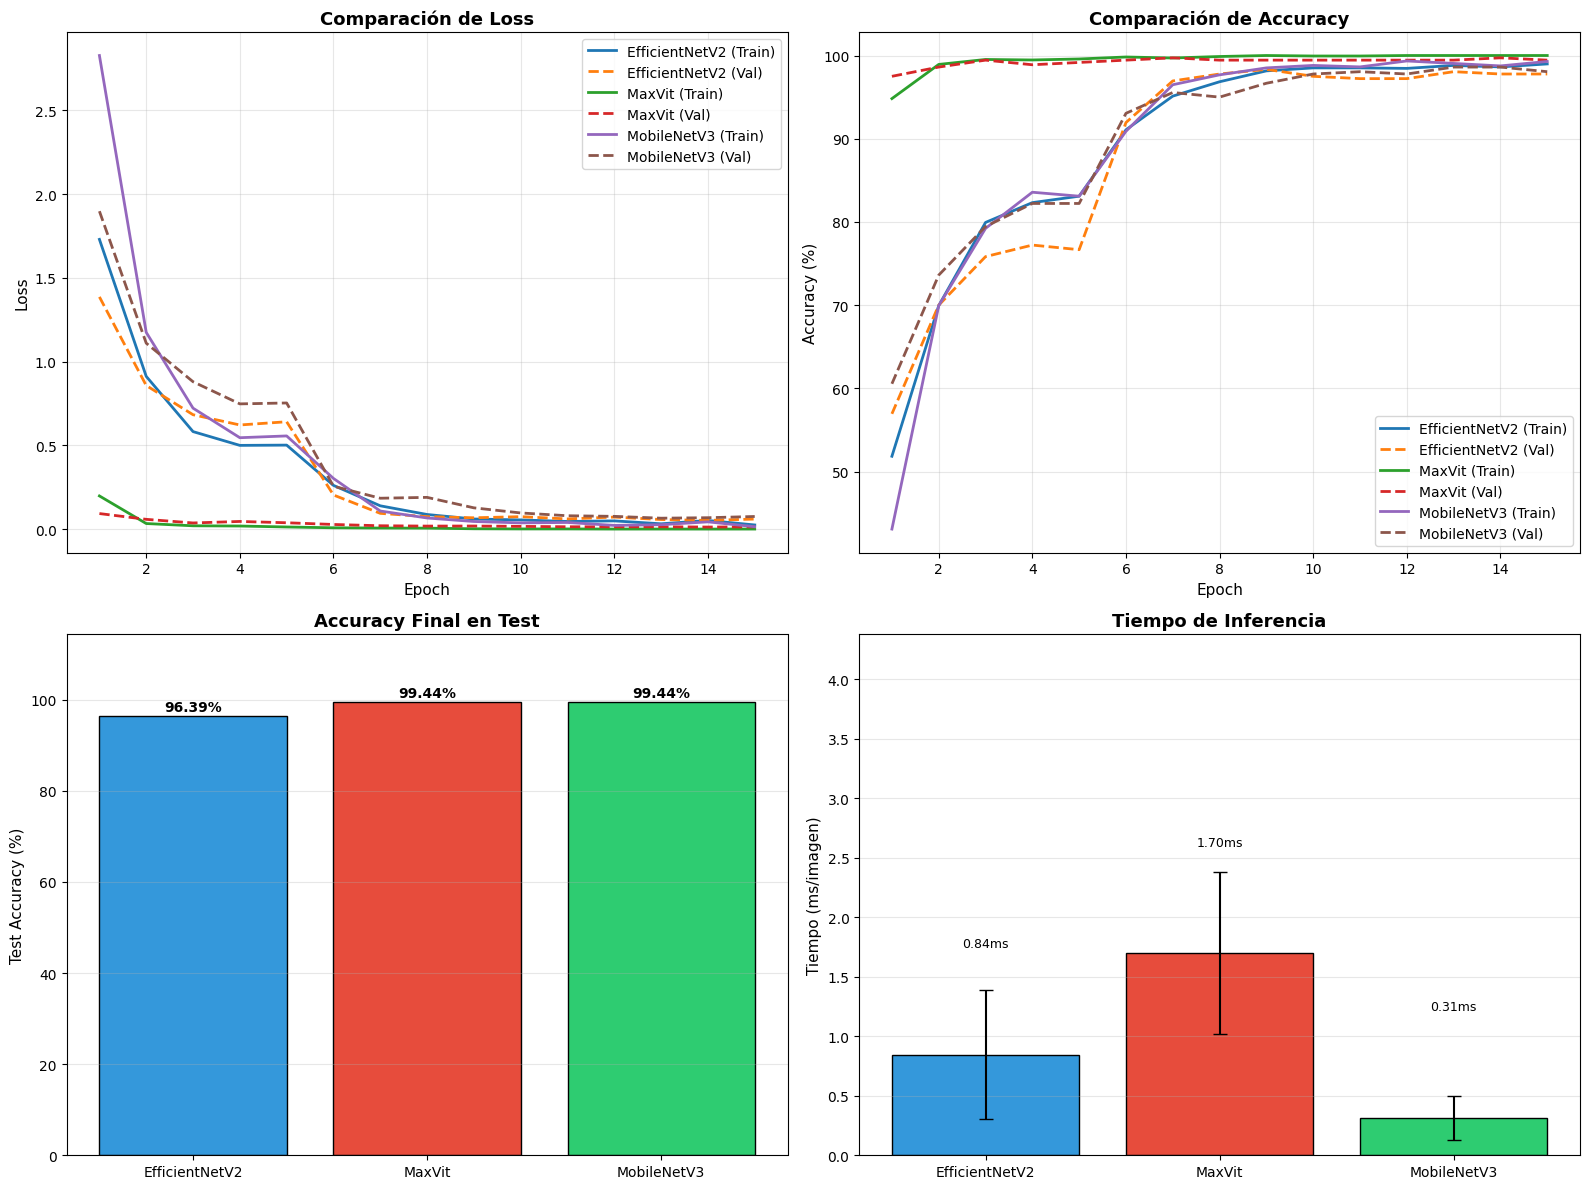

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Comparación de Loss durante entrenamiento
ax = axes[0, 0]
for model_name, data in results.items():
    epochs = range(1, len(data['history']['train_loss']) + 1)
    ax.plot(epochs, data['history']['train_loss'], label=f'{model_name} (Train)', linewidth=2)
    ax.plot(epochs, data['history']['val_loss'], '--', label=f'{model_name} (Val)', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Comparación de Loss', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Gráfico 2: Comparación de Accuracy durante entrenamiento
ax = axes[0, 1]
for model_name, data in results.items():
    epochs = range(1, len(data['history']['train_acc']) + 1)
    ax.plot(epochs, data['history']['train_acc'], label=f'{model_name} (Train)', linewidth=2)
    ax.plot(epochs, data['history']['val_acc'], '--', label=f'{model_name} (Val)', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Comparación de Accuracy', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Gráfico 3: Accuracy final en conjunto de test
ax = axes[1, 0]
model_names = list(results.keys())
test_accs = [results[m]['test_acc'] for m in model_names]
bars = ax.bar(model_names, test_accs, color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_ylabel('Test Accuracy (%)', fontsize=11)
ax.set_title('Accuracy Final en Test', fontsize=13, fontweight='bold')

max_acc = max(test_accs)
ax.margins(y=0.15) # Añade un 15% de espacio vertical extra automáticamente

ax.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, test_accs):
    ax.text(bar.get_x() + bar.get_width()/2,
            acc + 0.5, # Bajamos un poco el margen del texto
            f'{acc:.2f}%',
            ha='center',
            va='bottom',
            fontweight='bold',
            fontsize=10)

# Gráfico 4: Tiempo de inferencia promedio
ax = axes[1, 1]
inf_times = [results[m]['inference_time'][0] for m in model_names]
inf_stds = [results[m]['inference_time'][1] for m in model_names]
bars = ax.bar(model_names, inf_times, yerr=inf_stds, color=['#3498db', '#e74c3c', '#2ecc71'],
              edgecolor='black', capsize=5)
ax.set_ylabel('Tiempo (ms/imagen)', fontsize=11)
ax.set_title('Tiempo de Inferencia', fontsize=13, fontweight='bold')

ax.set_ylim([0, max(inf_times) + max(inf_stds) + 2])

ax.grid(axis='y', alpha=0.3)
for bar, t in zip(bars, inf_times):
    ax.text(bar.get_x() + bar.get_width()/2,
            t + max(inf_stds) + 0.2,
            f'{t:.2f}ms',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_overview.png', dpi=150, bbox_inches='tight')
plt.show()


La superior ofrece una visión sintética del comportamiento de los modelos, permitiendo contrastar no solo el resultado final, sino la "historia" de aprendizaje y el coste computacional asociado. A continuación, se analizan los hallazgos.

#### Dinámica de Convergencia y Adaptabilidad
El análisis de las curvas de entrenamiento (fila superior) revela una dicotomía interesante en la naturaleza de las arquitecturas evaluadas. Por un lado, **MaxVit** exhibe una curva de aprendizaje prácticamente plana desde el inicio, con una precisión en validación cercana a la perfección incluso durante la Fase 1, como ya intuíamos en los resultados preliminares anteriores.

Por el contrario, las arquitecturas basadas puramente en convoluciones, **EfficientNetV2** y **MobileNetV3**, muestran una clara dependencia de la Fase 2. Se observa un punto de inflexión crítico al inicio de esta (alrededor de la época 6), caracterizado por un descenso abrupto de la función de pérdida y un incremento sustancial del *accuracy*. Este comportamiento confirma que, aunque los extractores de características de ImageNet son útiles, las capas profundas de estas redes CNN requerían una modificación estructural de sus pesos para discriminar correctamente la morfología específica de las plantas. El hecho de que MobileNetV3 logre recuperarse tan drásticamente tras el desbloqueo de pesos demuestra una alta capacidad de aprendizaje.

Además, evaluando la forma general de todas las curvas, tienen una forma característica de un entrenamiento adecuado. Tanto la pérdida en *Val* y *Train* son muy cercanas a lo largo del entrenamiento, lo que da a entender de que no existe overfiting.

#### Saturación del Rendimiento en Test
Al examinar la precisión final en el conjunto de test (gráfico inferior izquierdo), nos encontramos ante un fenómeno de rendimientos exelentes. A pesar de la inmensa diferencia en complejidad parametral entre **MobileNetV3** (ligero) y **MaxVit** (pesado), ambos modelos convergen exactamente al mismo resultado de **$99.44$%**.

Este empate técnico tiene una implicación teórica importante: la complejidad del problema de clasificación (distinguir entre tres clases visualmente distintas) está acotada. El modelo más sencillo ya es capaz de capturar toda la variabilidad explicable del dataset. En consecuencia, la capacidad de modelado adicional que aportan los *Transformers* en MaxVit resulta redundante para esta tarea específica, ya que no se traduce en una ganancia de información discriminativa. Estamos ante un caso donde el "techo de cristal" lo impone el propio dataset y no la arquitectura.

#### Eficiencia Computacional y Estabilidad
La gráfica de tiempo de inferencia (inferior derecha) es quizás la más determinante para la viabilidad del proyecto. La disparidad en latencia es abismal: **MobileNetV3** ($0.31$ ms) es aproximadamente $5.5$ veces más rápido que **MaxVit** ($1.70$ ms) y casi 3 veces más veloz que **EfficientNetV2** ($0.84$ ms).

Más allá de la media, es crucial analizar la dispersión estadística representada por las barras de error (desviación estándar). **MaxVit** presenta una varianza considerablemente alta, lo que indica inestabilidad en los tiempos de respuesta. Esto es característico de operaciones complejas de atención global que pueden sufrir de accesos a memoria no contiguos en la GPU. En contraste, **MobileNetV3** muestra una varianza mínima, garantizando no solo rapidez, sino predictibilidad determinista, un requisito indispensable para sistemas de tiempo real donde se debe asegurar un *framerate* constante tras la detección de objetos con YOLO.

#### Oportunidad de trabajo de futuro

Con estos resultados tan positivos con modelos tan pequeños, sobretodo el mobilenet, da pie a poder ampliar el dataset con un mayor número de clases. De esta manera podríamos encontrar una desventaja real a usar modelos más pequeños, y modelos como MaxVit podrían tomar mayor importancia a pesar de la mayor latencia.

## Visualización 2: Matrices de Confusión

Si bien la exactitud global (*Accuracy*) nos ofrece una medida del éxito general, es una métrica agregada que puede ocultar sesgos importantes del modelo. Para entender **dónde** y **por qué** fallan nuestras arquitecturas, recurrimos a la Matriz de Confusión.

En este apartado, comparamos las matrices de los tres modelos para determinar si los errores son aleatorios o si responden a un patrón estructural de cada arquitectura.

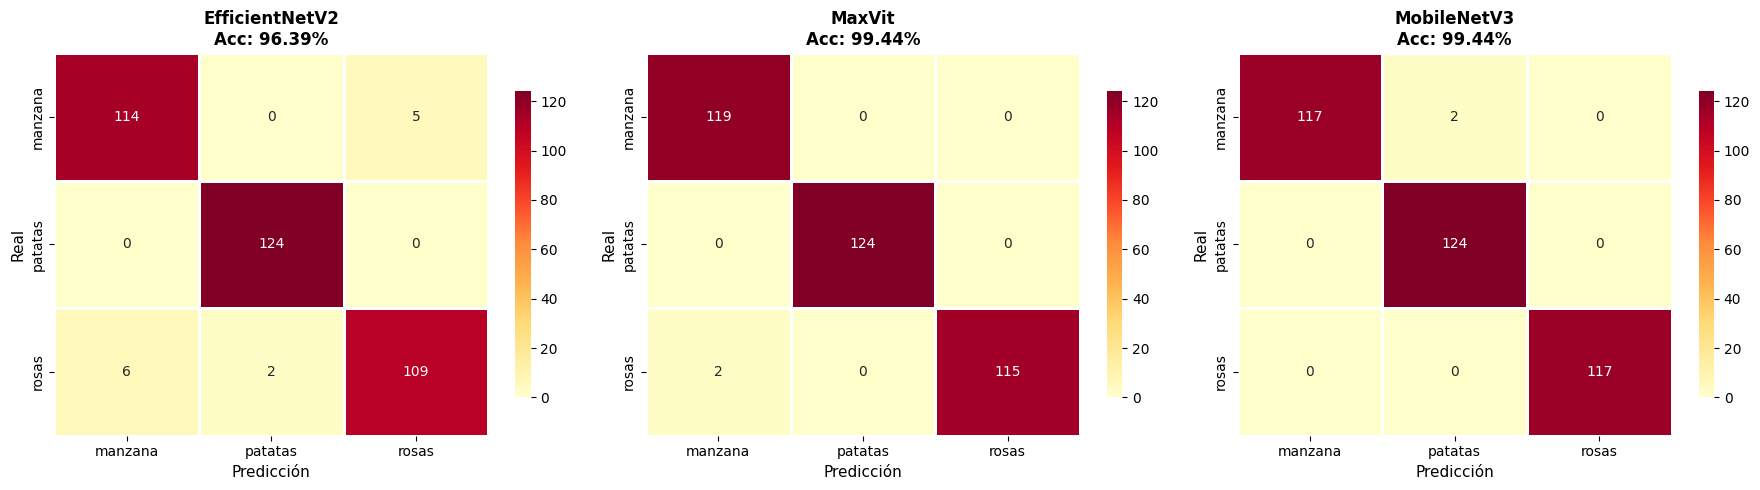

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, data) in enumerate(results.items()):
    y_pred, y_true, _ = data['predictions']
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=CLASSES, yticklabels=CLASSES,
                linewidths=1, linecolor='white', ax=axes[idx],
                cbar_kws={'shrink': 0.8})
    axes[idx].set_xlabel('Predicción', fontsize=11)
    axes[idx].set_ylabel('Real', fontsize=11)
    axes[idx].set_title(f'{model_name}\nAcc: {data["test_acc"]:.2f}%',
                        fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

El examen detallado de las matrices de confusión permite ir más allá de la tasa de acierto global y comprender la naturaleza de los errores cometidos por cada arquitectura. En primer lugar, se observa un patrón transversal de excelencia en la identificación de la clase "patatas". Los tres modelos, independientemente de su complejidad, lograron una clasificación perfecta (100% de sensibilidad) para esta categoría.

Sin embargo, las diferencias arquitectónicas se manifiestan al analizar las clases "manzana" y "rosas". El modelo **EfficientNetV2** revela una limitación estructural significativa al intentar distinguir entre estas dos categorías. Se aprecia una confusión bidireccional notable: clasificó erróneamente un subconjunto de manzanas como rosas y viceversa. Este solapamiento semántico indica que, para una red convolucional convencional de este tamaño, los atributos visuales compartidos (como la tonalidad del follaje o la estructura de las hojas) predominan sobre los rasgos distintivos, generando una frontera de decisión difusa entre ambas especies.

Por el contrario, el análisis comparativo entre los modelos de mejor rendimiento, **MaxVit** y **MobileNetV3**, arroja matices interesantes. Aunque ambos alcanzaron idéntica precisión global con solo dos errores absolutos cada uno, la distribución cualitativa de estos fallos difiere. **MaxVit** demostró una robustez perfecta en manzanas y patatas, pero falló levemente al clasificar dos instancias de rosas como manzanas, replicando a muy pequeña escala la confusión observada en EfficientNet.

Sorprendentemente, **MobileNetV3** exhibió un comportamiento distintivo: fue el único modelo capaz de clasificar perfectamente la clase "rosas", que había resultado ser la más problemática para EfficientNet. Sus únicos errores marginales ocurrieron al confundir manzanas con patatas. Este hallazgo es de gran relevancia para la selección del modelo, pues demuestra que la arquitectura ligera de MobileNetV3 no solo es más rápida, sino que ha logrado generar descriptores visuales lo suficientemente ricos para resolver totalmente la ambigüedad entre manzanas y rosas que afectaba a modelos más pesados, validando su idoneidad para el despliegue final.

## Visualización 3: Métricas por Clase

Si bien la matriz de confusión ofrece un conteo bruto de los errores, para comparar formalmente el rendimiento entre modelos es necesario normalizar estos valores mediante métricas estandarizadas: **Precisión (Precision)**, **Sensibilidad (Recall)** y **F1-Score**.

Esta visualización desagregada es crítica porque, en aplicaciones de agricultura de precisión, los costes de los errores no siempre son simétricos.
*   La **Precisión** responde a la pregunta: *"Cuando el modelo predice 'manzana', ¿qué tan seguros estamos de que realmente lo es?"*. Una baja precisión implica muchos falsos positivos.
*   El **Recall** responde a: *"De todas las 'manzanas' que había en el campo, ¿cuántas fue capaz de encontrar el modelo?"*. Un bajo recall implica que estamos perdiendo información (falsos negativos).
*   El **F1-Score** se presenta como la media armónica de ambas, ofreciendo una medida única de la robustez del clasificador para cada clase específica.

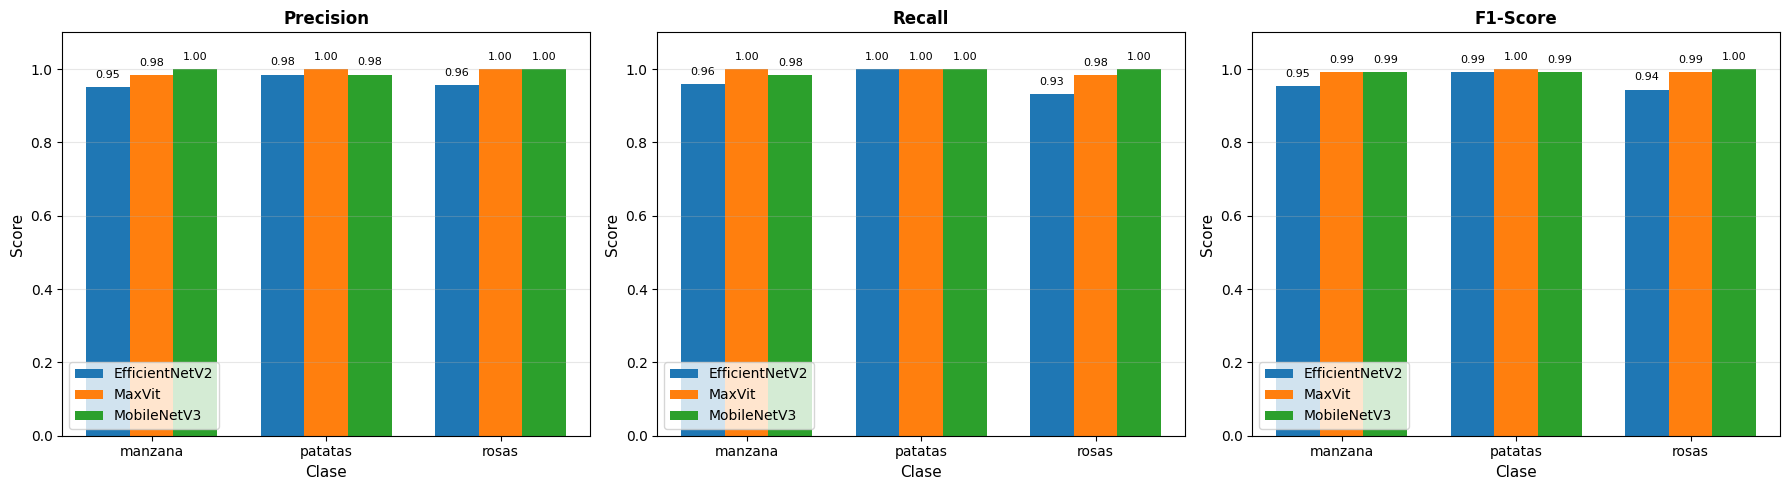

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric_name in enumerate(['Precision', 'Recall', 'F1-Score']):
    ax = axes[idx]
    x = np.arange(len(CLASSES))
    width = 0.25

    for i, (model_name, data) in enumerate(results.items()):
        y_pred, y_true, _ = data['predictions']
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

        if metric_name == 'Precision':
            values = precision
        elif metric_name == 'Recall':
            values = recall
        else:
            values = f1

        offset = width * (i - 1)
        bars = ax.bar(x + offset, values, width, label=model_name)

        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2f}',
                   ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Clase', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(metric_name, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASSES)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('metrics_comparison_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

La descomposición de las métricas de rendimiento corrobora la superioridad estadística de las arquitecturas modernas frente a EfficientNetV2 en este dominio específico. Al analizar el **Recall**, se observa que EfficientNetV2 presenta una caída significativa en la clase "rosas", alcanzando solo un 0.93. Esto implica que, en un escenario de despliegue real, este modelo omitiría el 7% de las rosas presentes en la imagen, un margen de error probablemente inaceptable si el objetivo es el conteo exhaustivo o la detección de plagas en dicha especie. Esta debilidad se refleja consecuentemente en su **F1-Score**, que desciende a $0.94$, marcando la cota inferior del experimento.

Por el contrario, la comparativa entre los modelos líderes, **MaxVit** y **MobileNetV3**, revela matices sobre sus sesgos operativos. Si observamos la clase "manzana", se aprecia un interesante compromiso: mientras que MaxVit alcanza un **Recall** perfecto de 1.00, detecta todas las manzanas, pero con una **Precisión** de $0.98$. MobileNetV3 invierte esta relación, logrando una **Precisión** perfecta de $1.00$, todo lo que dice que es manzana, lo es; con un **Recall** de $0.98$. Desde una perspectiva de ingeniería, MobileNetV3 se comporta aquí como un modelo más "conservador" y fiable, minimizando los falsos positivos.

Sin embargo, el dato más contundente a favor de la arquitectura ligera se encuentra en la clase "rosas". MobileNetV3 logra la puntuación perfecta ($1.00$) simultáneamente en **Precisión**, **Recall** y **F1-Score**, superando ligeramente a MaxVit, que se queda en un **F1** de $0.99$. Este hallazgo es contraintuitivo y relevante: el modelo con menor capacidad teórica (MobileNetV3) ha logrado generar una representación del espacio latente para las rosas más limpia y separable que el modelo basado en Transformers. Este dominio absoluto de la clase más difícil valida definitivamente a MobileNetV3 no solo como la opción económica, sino como la más robusta para la tarea global.

## Visualización 4: Análisis de Confianza

Para que un modelo sea apto para un entorno de producción, no basta con que tenga una alta tasa de aciertos (*Accuracy*); debe estar bien **calibrado**. Un modelo calibrado es aquel cuya probabilidad predicha (confianza) se correlaciona con su probabilidad real de acertar.

Esta visualización audita la "seguridad" de las redes neuronales evaluadas mediante dos perspectivas:
1.  **Histogramas de Densidad (Izquierda):** Muestran la distribución de las probabilidades máximas. En un escenario ideal, esperamos ver una separación clara: las predicciones correctas (verde) acumuladas en la zona de alta confianza ($>0.9$) y las incorrectas (rojo) dispersas en zonas de baja confianza. Esto nos indica si el modelo es "consciente" de su incertidumbre.
2.  **Precisión Condicionada (Derecha):** Evalúa la fiabilidad por tramos. Nos permite responder a la pregunta: *"Si el sistema dice que es una manzana con un 90% de seguridad, ¿cuál es la probabilidad real de que lo sea?"*. Esta métrica es fundamental para establecer **umbrales de corte (thresholds)** en el pipeline final con YOLO, permitiendo descartar detecciones dudosas.

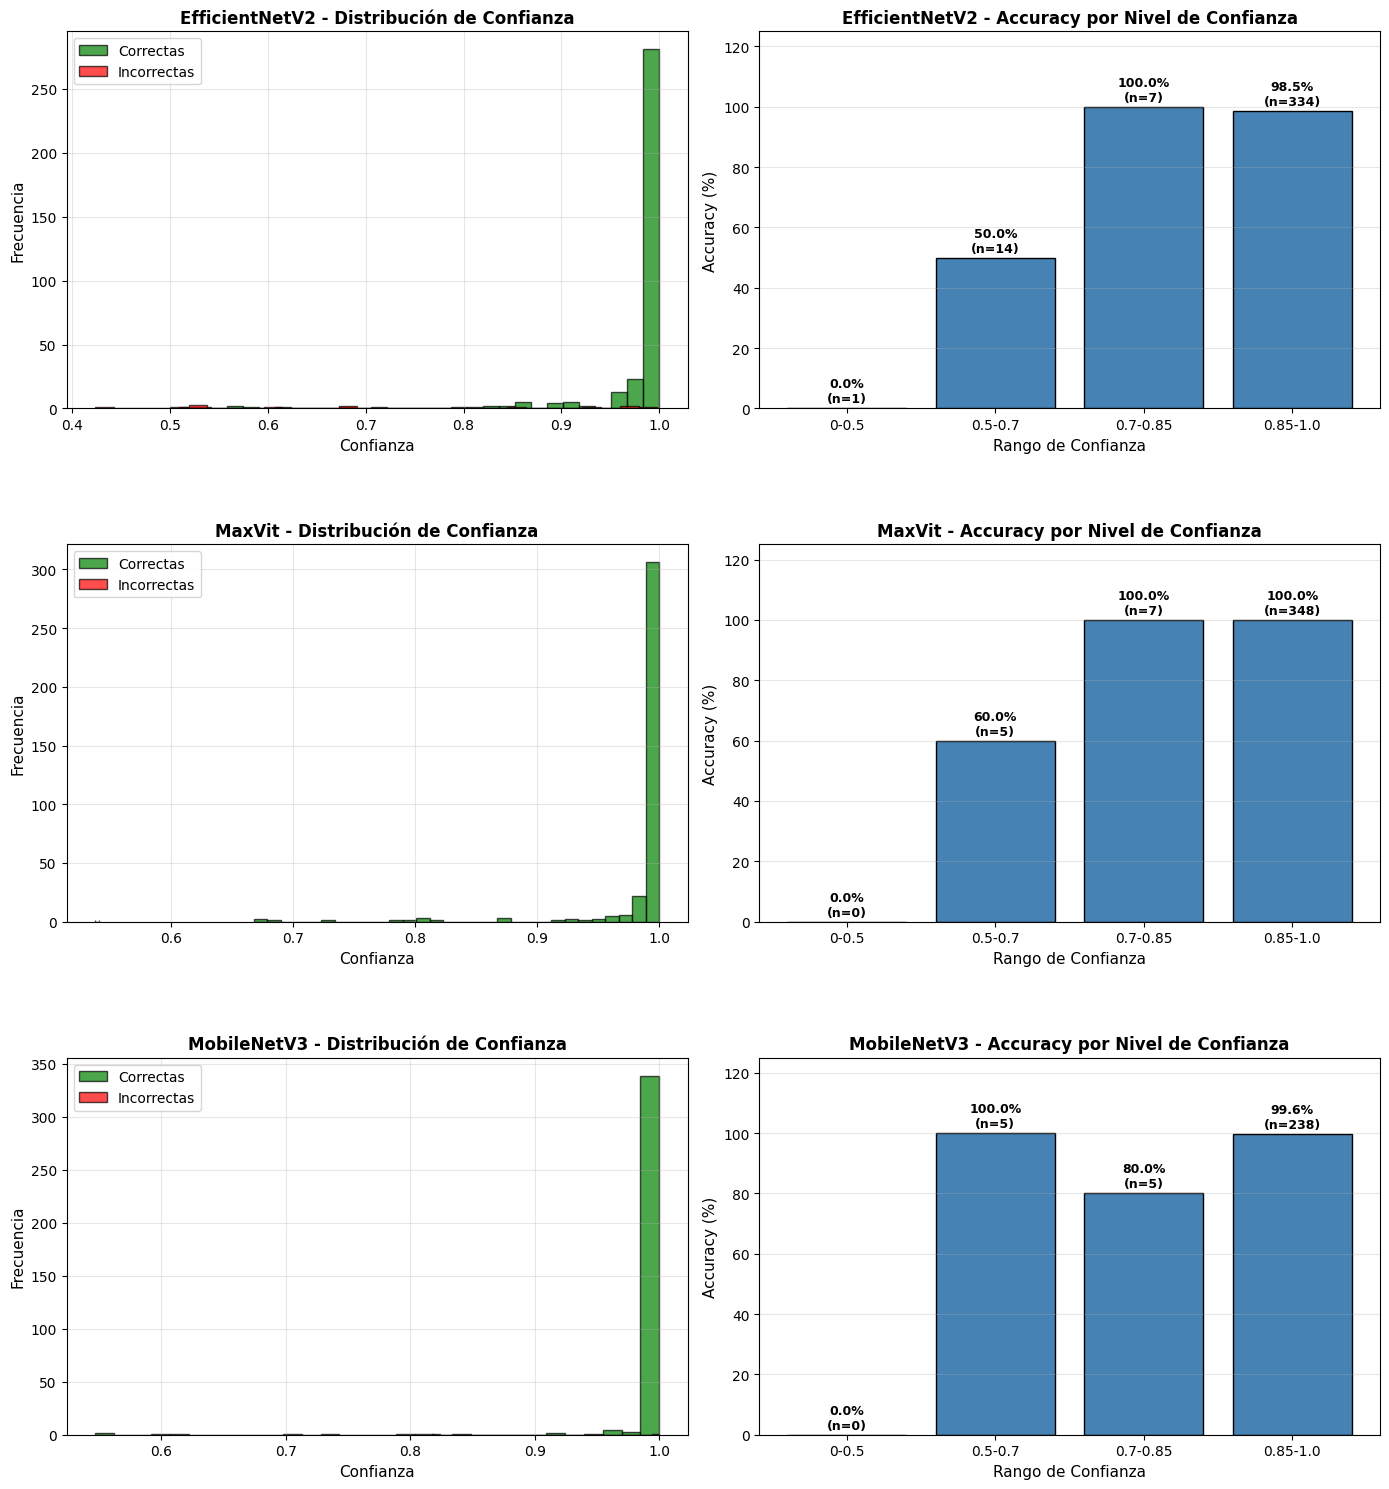

In [ ]:
# Aseguramos que axes siempre sea una matriz de 2 dimensiones incluso con un solo modelo
fig, axes = plt.subplots(len(results), 2, figsize=(14, 5 * len(results)))
if len(results) == 1:
    axes = axes.reshape(1, 2)

for idx, (model_name, data) in enumerate(results.items()):
    y_pred, y_true, y_prob = data['predictions']
    max_probs = y_prob.max(axis=1)
    correct_mask = (y_pred == y_true)

    # Gráfico izquierdo: Histograma de confianza
    ax1 = axes[idx, 0]
    ax1.hist(max_probs[correct_mask], bins=30, alpha=0.7, color='green',
             label='Correctas', edgecolor='black')
    ax1.hist(max_probs[~correct_mask], bins=30, alpha=0.7, color='red',
             label='Incorrectas', edgecolor='black')
    ax1.set_xlabel('Confianza', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.set_title(f'{model_name} - Distribución de Confianza', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Gráfico derecho: Accuracy por rango de confianza
    ax2 = axes[idx, 1]
    conf_ranges = [(0, 0.5), (0.5, 0.7), (0.7, 0.85), (0.85, 1.0)]
    accuracies = []
    counts = []

    for low, high in conf_ranges:
        mask = (max_probs >= low) & (max_probs < high)
        counts.append(mask.sum())
        if mask.sum() > 0:
            acc = correct_mask[mask].mean()
            accuracies.append(acc * 100)
        else:
            accuracies.append(0)

    bars = ax2.bar(range(len(conf_ranges)), accuracies, color='steelblue', edgecolor='black')

    ax2.margins(y=0.25)

    ax2.set_xlabel('Rango de Confianza', fontsize=11)
    ax2.set_ylabel('Accuracy (%)', fontsize=11)
    ax2.set_title(f'{model_name} - Accuracy por Nivel de Confianza',
                  fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(conf_ranges)))
    ax2.set_xticklabels([f'{low}-{high}' for low, high in conf_ranges])
    ax2.grid(axis='y', alpha=0.3)

    for i, (v, c) in enumerate(zip(accuracies, counts)):
        ax2.text(i, v + 1, f'{v:.1f}%\n(n={c})',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout(h_pad=5.0)
plt.savefig('confidence_analysis_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

El estudio de la distribución de confianza y la precisión condicionada revela comportamientos críticos para la implementación del modelo en un entorno productivo. En primer lugar, los histogramas de densidad (columna izquierda) evidencian que las tres arquitecturas exhiben una **alta nitidez** en sus predicciones; la masa de probabilidad se concentra agresivamente en el rango superior ($0.9 - 1.0$). Esto es característico de modelos que han logrado una convergencia robusta y han encontrado fronteras de decisión muy claras entre las clases "manzana", "patata" y "rosa".

Sin embargo, al examinar la fiabilidad por tramos (columna derecha), emergen diferencias cualitativas importantes. **EfficientNetV2** muestra signos de una calibración subóptima comparada con sus competidores. A pesar de tener una confianza alta en el tramo superior ($0.85-1.0$), su precisión desciende al 98.5%. Esto implica la existencia de "errores confiados" (*confident errors*): el modelo asignó una probabilidad muy alta a predicciones que resultaron ser falsas. Además, es el modelo que acumula más incertidumbre, con un número significativo de muestras ($n=14$) en rangos de confianza medios, donde su precisión cae al 50%.

Por el contrario, **MaxVit** demuestra un comportamiento determinista ideal. En los rangos de confianza superiores a 0.7, su precisión es absoluta (100%), lo que indica una calibración perfecta en la zona operativa. No obstante, es **MobileNetV3** el que presenta el perfil más interesante para el despliegue. Aunque se observa una anomalía estadística en el rango $0.7-0.85$ (donde la precisión cae al 80%), esto debe interpretarse con cautela debido al tamaño muestral insignificante ($n=5$), lo que sugiere que es un artefacto estadístico y no un fallo sistémico. Lo verdaderamente relevante es su comportamiento en el rango superior ($0.85-1.0$): concentra la inmensa mayoría de las muestras de test ($n=238$) con una fiabilidad del 99.6%.

En conclusión, estos datos validan la estrategia de integración con el detector YOLO. Dado el comportamiento observado en MaxVit y MobileNetV3, se puede establecer un **umbral de corte (*confidence threshold*) conservador de 0.85**. Operando sobre este límite, el sistema de clasificación virtualmente elimina los falsos positivos, garantizando que las decisiones tomadas por el robot o sistema de monitoreo se basen en predicciones de altísima certeza.

# Conclusión Final

El presente estudio tenía como objetivo evaluar y seleccionar una arquitectura de clasificación para integrarse como la primera etapa de un pipeline de visión artificial (Clasificación + Detección YOLO). Tras someter a tres paradigmas distintos (*EfficientNetV2, MaxVit y MobileNetV3*) a un protocolo experimental riguroso, se presentan las siguientes conclusiones:

### 1. Rendimientos Decrecientes en Complejidad
Los experimentos refutan la hipótesis de que una mayor complejidad arquitectónica garantiza un mejor rendimiento en este dominio específico.
*   **MaxVit** (basado en Transformers y con ~30M de parámetros) y **MobileNetV3** (basado en CNNs ligeras y ~1.5M de parámetros) alcanzaron un empate técnico en precisión (**99.44%**).
*   Esto indica que la complejidad intrínseca del problema de clasificación de estas tres especies vegetales está acotada. La capacidad de modelado global ("atención") de MaxVit resulta redundante, ya que las características locales extraídas por MobileNetV3 son suficientes para resolver la tarea con la misma eficacia.

### 2. Análisis de Errores y Robustez
Cualitativamente, **MobileNetV3** demostró ser el modelo más robusto. Mientras que *EfficientNetV2* sufrió confusiones semánticas significativas entre las clases "manzana" y "rosas" (debido probablemente a similitudes en el follaje), y *MaxVit* cometió errores puntuales en estas mismas clases, **MobileNetV3 fue el único capaz de clasificar perfectamente la clase "Rosas" (F1-Score 1.0)**. Esto sugiere que sus filtros convolucionales, optimizados mediante búsqueda de arquitectura neuronal (NAS), lograron aislar características discriminativas únicas que pasaron desapercibidas para modelos más grandes.

### 3. Viabilidad Operativa (El Factor Decisivo)
Dado que este clasificador debe operar en serie antes de un detector de objetos (YOLO), la latencia es una restricción crítica.
*   **MaxVit:** Con un tiempo de inferencia de **~1.70 ms** y una alta varianza, representa un cuello de botella potencial para el sistema en tiempo real.
*   **MobileNetV3:** Con **~0.31 ms**, es aproximadamente **5.5 veces más rápido** que MaxVit.

### Veredicto: Selección del Modelo
Basándonos en el principio de eficiencia de Pareto, seleccionamos **MobileNetV3-Small** como el modelo ganador para el proyecto final.

**Justificación:** MobileNetV3 ofrece la máxima precisión teórica observada en el experimento (igualando al modelo basado en transformers), pero con una fracción del coste computacional. Su integración permitirá reservar la mayor parte de los recursos de la GPU para la tarea más pesada (la detección de objetos con YOLO), garantizando así que el pipeline completo pueda operar a una tasa de fotogramas (FPS) fluida y con una fiabilidad de clasificación superior al 99%.